In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sklearn as skl
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.pyplot as plt

In [2]:
# Load data
raw_data = pd.read_csv("../Datasets/Three Coefficient System Data.csv")
print(raw_data.head())

         D1         N2         N1   RiseTime  TransientTime  SettlingTime  \
0 -7.792284   5.479346   6.716621   1.387282       2.590738      2.610738   
1 -8.421525   5.120316   0.353875  31.358374      56.150816     56.150816   
2 -7.190644   7.520692  12.880123   0.977723       1.865514      1.892572   
3 -0.999792   3.934565   3.444088   1.817707       3.844851      4.141904   
4  3.242414  14.304431  50.128112   0.090039       0.798297      0.798297   

   SettlingMin  SettlingMax  Overshoot  Undershoot       Peak    PeakTime  
0    -1.160146    -1.046628   0.000000    3.758780   1.160146    7.437680  
1   -23.781914   -21.474148   0.000000   -0.000000  23.781914  104.497226  
2    -0.557838    -0.502913   0.000000    7.321072   0.557838    3.125033  
3    -0.289938    -0.261309   0.000000   47.523859   0.289938    6.270974  
4     0.058454     0.076270  17.914613   -0.000000   0.076270    0.262541  


In [3]:
# TODO: apply one-hot encoding here directly
# Determine the appropriate label for each entry (-1 for undershoot, 1 for overshoot, 0 for neither)
labels = np.empty(raw_data.shape[0])
for i in range(raw_data.shape[0]):
    if raw_data['Overshoot'][i] > 1e-5:
        labels[i] = 1
    elif raw_data['Undershoot'][i] > 1e-5:
        labels[i] = -1
    else:
        labels[i] = 0

print(labels[0:10])

[-1.  0. -1. -1.  1.  0. -1. -1.  1.  0.]


In [4]:
# Convert to numpy array
data_array = raw_data.to_numpy()

# Separate the coefficients, which form the inputs to the neural network, from the rest of the data
coefficients = data_array[:,0:3]
print(coefficients[0:10,:])
print(coefficients.shape)

# Use StandardScaler to remove the mean and scale to unit variance
scaler = preprocessing.StandardScaler().fit(coefficients)
scaled_coefficients = scaler.transform(coefficients)
print(scaled_coefficients[0:10,:])
print(scaled_coefficients.shape)

[[-7.79228424  5.47934562  6.71662058]
 [-8.42152544  5.12031577  0.35387548]
 [-7.19064401  7.52069159 12.88012284]
 [-0.99979183  3.93456491  3.44408765]
 [ 3.24241381 14.30443065 50.12811171]
 [ 1.33743502  2.03751786  0.33664909]
 [-3.54696119  8.4022494  10.30029108]
 [-0.86277595  5.84596197  4.41055548]
 [ 2.3810471  14.3529412  51.46699745]
 [ 2.83216256 11.77086991 19.55988402]]
(10000, 3)
[[-1.34584063 -1.11996452 -0.83356975]
 [-1.45478893 -1.20839967 -1.12254131]
 [-1.24167124 -0.61714634 -0.55364703]
 [-0.16977259 -1.50047024 -0.98219569]
 [ 0.56473283  1.05380377  1.13801428]
 [ 0.23490035 -1.96774514 -1.12332367]
 [-0.61079546 -0.40000369 -0.67081313]
 [-0.14604934 -1.02966069 -0.93830241]
 [ 0.41559378  1.06575274  1.19882136]
 [ 0.49370097  0.42974474 -0.2502778 ]]
(10000, 3)


In [5]:
# Use one-hot encoding on the labels
enc_labels = keras.utils.to_categorical(labels,3)
print(enc_labels[0:10])
print(enc_labels.shape)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
(10000, 3)


In [6]:
# Reserve 10% of the data as test data, and use the rest as training data
train_inputs,test_inputs,train_labels,test_labels = model_selection.train_test_split(scaled_coefficients, enc_labels, test_size=0.10)
print(train_inputs.shape, train_labels.shape,test_inputs.shape, test_labels.shape)

(9000, 3) (9000, 3) (1000, 3) (1000, 3)


In [7]:
# Use a sequential model for classification
model = tf.keras.models.Sequential()
# First hidden layer: 128 nodes, RELU activation function
model.add(keras.layers.Dense(128,
                             input_shape=(3,),
                              name='layer_1',
                              activation='relu'))
# Second hidden layer: 128 nodes, RELU activation function
model.add(keras.layers.Dense(128,
                              name='layer_2',
                              activation='relu'))
# Output layer: softmax activation function
model.add(keras.layers.Dense(3,
                             name='output_layer',
                             activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 128)               512       
                                                                 
 layer_2 (Dense)             (None, 128)               16512     
                                                                 
 output_layer (Dense)        (None, 3)                 387       
                                                                 
Total params: 17,411
Trainable params: 17,411
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
450/450 [==============================] - 1s 990us/step - loss: 0.2512 - accuracy: 0.9186 - val_loss: 0.1277 - val_accuracy: 0.9567
Epoch 2/10
450/450 [==============================] - 0s 777us/step - loss: 0.1195 - accuracy: 0.9571 - val_loss: 0.0879 - val_accuracy: 0.9733
Epoch 3/10
450/450 [==============================] - 0s 730us/step - loss: 0.0974 - accuracy: 0.9642 - val_loss: 0.0724 - val_accuracy: 0.9694
Epoch 4/10
450/450 [==============================] - 0s 763us/step - loss: 0.0867 - accuracy: 0.9647 - val_loss: 0.0695 - val_accuracy: 0.9694
Epoch 5/10
450/450 [==============================] - 0s 705us/step - loss: 0.0809 - accuracy: 0.9665 - val_loss: 0.0625 - val_accuracy: 0.9711
Epoch 6/10
450/450 [==============================] - 0s 705us/step - loss: 0.0767 - accuracy: 0.9669 - val_loss: 0.0647 - val_accuracy: 0.9756
Epoch 7/10
450/450 [==============================] - 0s 742us/step - loss: 0.0743 - accuracy: 0.9696 - val_loss: 0.0590 - val_accuracy:

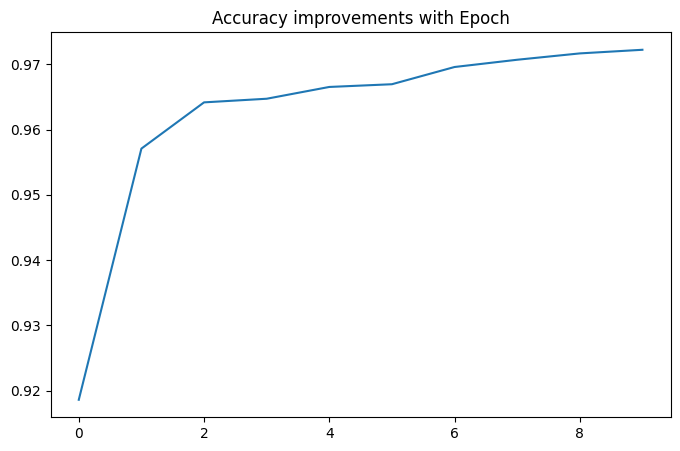


Evaluation against Test Dataset :
------------------------------------
32/32 [==============================] - 0s 859us/step - loss: 0.0629 - accuracy: 0.9730


[0.06294583529233932, 0.9729999899864197]

In [8]:
# Perform training

history=model.fit(train_inputs,
          train_labels,
          batch_size = 16,
          epochs = 10,
          verbose = 1,
          validation_split = 0.2)

# Code borrowed from Kumaran Ponnambalam's LinkedIn Learning course
# Check the accuracy after each epoch
pd.DataFrame(history.history)["accuracy"].plot(figsize=(8, 5))
plt.title("Accuracy improvements with Epoch")
plt.show()

#Evaluate the model against the test dataset and print results
print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(test_inputs, test_labels)

In [9]:
# Export model
model.save("OUID_3C_First_Try")

INFO:tensorflow:Assets written to: OUID_3C_First_Try\assets


INFO:tensorflow:Assets written to: OUID_3C_First_Try\assets
